In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import random

In [2]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots'
my_data_dir = proj_dir + '/my_data'
nb_dir = proj_dir + '/notebooks'

In [3]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [4]:
from letkf import *

In [5]:
random.seed(362512)

In [6]:
## Which vertical columns are we considering here?
which_columns = {
  'lons' : [-174.5, 45.5, 75.5, -129.5, 160.5],
  'lats' : [-29.5, -59.5, -24.5, 0.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific', 'southern_ocean', 'indian_ocean', 'tropical_pacific', 'north_pacific']
}

In [7]:
# Load indian ocean covariance matrix
io_cov = np.load(my_data_dir +'/indian_ocean_cov.npy')
io_cov = io_cov[:64, :64]
io_cov_sqrt = np.linalg.cholesky(io_cov)

In [8]:
# Get covariance matrix
this_cov = io_cov
this_cov_sqrt = io_cov_sqrt
num_levs = this_cov.shape[0]

In [9]:
# Get correlation matrix
io_cor = np.load(my_data_dir +'/indian_ocean_cor.npy')
io_cor = io_cor[:64, :64]
this_cor = io_cor

In [10]:
## Set observation operator
HofX = np.zeros((1, num_levs))
HofX[0, -1] = 1

In [11]:
## Get state and observation positions and localization radii
atm_p = np.load(my_data_dir+'/atm_p.npy')
pos_state = np.log(atm_p)
pos_ob = pos_state[0]

In [12]:
## Generate synthetic observations
xt = this_cov_sqrt @ np.random.normal(size=(num_levs, 1))
y_ob = HofX @  xt

In [53]:
# Set ensemble size
ens_size = 2000

In [54]:
## Generate ensemble
rnd = np.random.normal(size=(num_levs, ens_size))
x_ens = this_cov_sqrt @ rnd
P_ens = np.cov(x_ens)
C_ens = np.corrcoef(x_ens)

In [55]:
## Set observation error variance equal to background error variance
R = HofX @ P_ens @ HofX.transpose()
R_inv = np.reciprocal(R)

In [56]:
## No localization
analysis_mean_no_loc, analysis_cov_no_loc = letkf(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 1e5), np.full_like(pos_ob, 1e5), inflate=1, use_loc=False)

In [57]:
## Calculate analysis increments
background_mean = np.mean(x_ens, 1)
true_increment = xt[:,0] - background_mean
da_increment_no_loc = analysis_mean_no_loc - background_mean
innovation = y_ob - HofX @ background_mean
enkf_increment = (P_ens[-1,:]/(2*P_ens[-1,-1])) * innovation # Note this is not a general formula!
kf_increment = (this_cov[-1,:]/(2*this_cov[-1,-1])) * innovation # Note this is not a general formula!

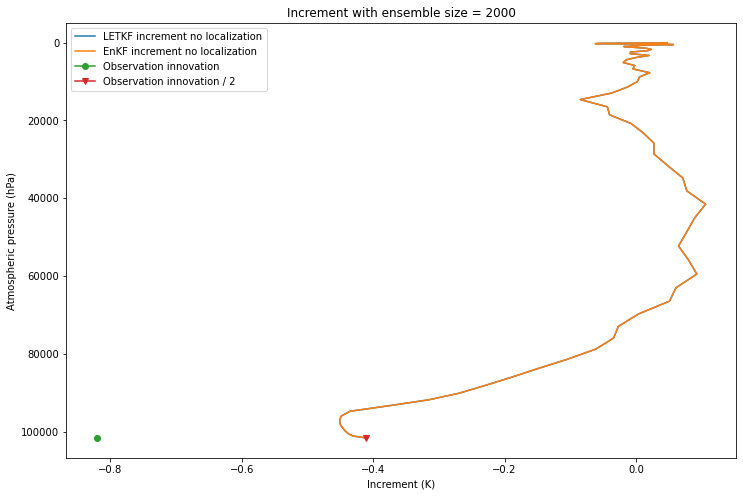

In [58]:
## Plot increment and observation
plt.plot(da_increment_no_loc, atm_p, label='LETKF increment no localization')
plt.plot(enkf_increment[0, :], atm_p, label='EnKF increment no localization')
plt.plot(innovation, atm_p[-1], marker='o', label='Observation innovation')
plt.plot(innovation/2, atm_p[-1], marker='v', label='Observation innovation / 2')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Increment with ensemble size = '+str(ens_size))
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_increment_letkf_vs_enkf_ens_size_'+str(ens_size))
plt.show()

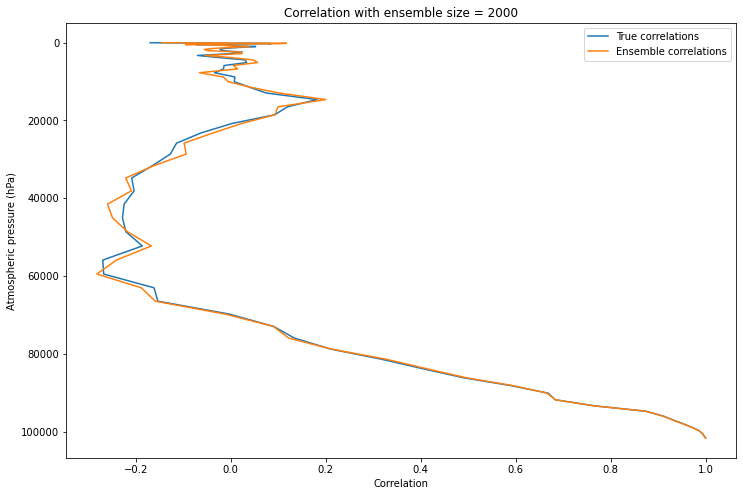

In [59]:
## Plot ensemble and true correlations
plt.plot(this_cor[-1, :], atm_p, label='True correlations')
plt.plot(C_ens[-1, :], atm_p, label='Ensemble correlations')
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Correlation with ensemble size = '+str(ens_size))
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_corr_ens_size_'+str(ens_size))
plt.show()

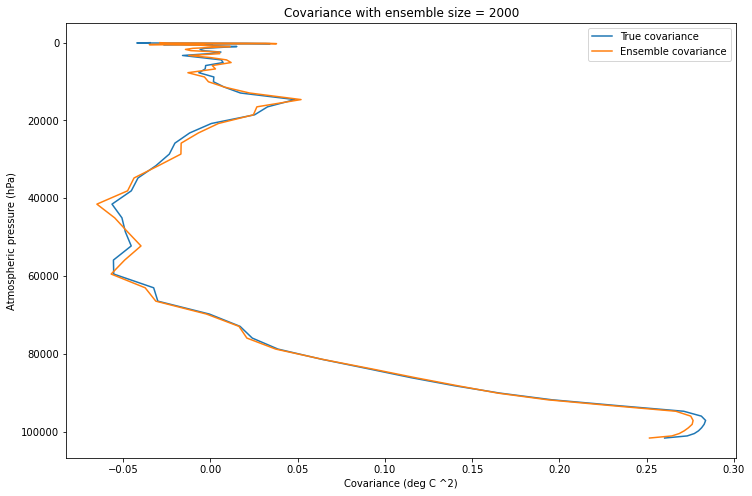

In [60]:
## Plot ensemble and true covariance
plt.plot(this_cov[-1, :], atm_p, label='True covariance')
plt.plot(P_ens[-1, :], atm_p, label='Ensemble covariance')
plt.legend()
plt.xlabel('Covariance (deg C ^2)')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Covariance with ensemble size = '+str(ens_size))
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_cov_ens_size_'+str(ens_size))
plt.show()